In [20]:
#libraries import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os

In [21]:
# to check gpu device is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Create a label map to convert the string labels to numerical indices
# We will label each disease type in numbers
label_map = {'Atelectasis': 0,
             'Cardiomegaly': 1,
             'Effusion': 2,
             'Infiltration': 3,
             'Mass': 4,
             'Nodule': 5,
             'Pneumonia': 6,
             'Pneumothorax': 7,
             'Consolidation': 8,
             'Edema': 9,
             'Emphysema': 10,
             'Fibrosis': 11,
             'Pleural_Thickening': 12,
             'Hernia': 13
            # 'No Finding': 14
            }
len(label_map) #to dispaly length of classes 

14

In [6]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
# make class of our dataset
class NIH_Chest_Xray_Dataset(Dataset):
    def __init__(self, data_dir, train_test_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.train_test_file = train_test_file
        train_test_img_list = [line.rstrip() for line in open(train_test_file)]
        # Read the CSV file with the image labels
        df = pd.read_csv(os.path.join(data_dir, 'Data_Entry_2017.csv'))

        # Loop through the images and labels, and store the paths and labels in lists  
        
        for i, row in df.iterrows():
            img_name = row['Image Index']
            if img_name in train_test_img_list:
                for i in range (1,13):
                #for i in range (1,2):    
                    img_path = os.path.join(data_dir,f'images_00{i}/images/',img_name)
                
                    if os.path.isfile(img_path):
                        self.image_paths.append(img_path)
                        label = row['Finding Labels'].split("|")
                        self.labels.append(label)
                        break

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]  #images
        label = self.labels[idx]  #labels in csv 
        
        # Open the image file and apply the transforms (if any)
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        num_labels = 14 # There are 14 possible labels in the dataset
        binary_label = torch.zeros(num_labels)
        
        for l in label:
            if(l=='No Finding'):
                continue
            binary_label[label_map[l]] = 1

        return img, binary_label


In [14]:
#this cell will take approx (5-10) minutes to run on 16gb gpu 
#as it is transforming image dimensions for input in vision transformers, resizing (to 224,224)

from torchvision import datasets, transforms
data_dir = '/kaggle/input/data/'  #change your directory here

#pre-processing 
transform = transforms.Compose([   #transforms for data augmentation
    transforms.Resize((224, 224)),
     transforms.RandomRotation(degrees=10),
     transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert to tensors
    # normalize the data
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_file = os.path.join(data_dir, 'train_val_list.txt')
test_file = os.path.join(data_dir, 'test_list.txt')
# datasets in pytorch
train_dataset = NIH_Chest_Xray_Dataset(data_dir, train_test_file=train_file, transform=transform)

print(len(train_dataset))

67091


In [16]:
#datasets
test_dataset = NIH_Chest_Xray_Dataset(data_dir, train_test_file=test_file, transform=transform)
print(len(test_dataset))

17908


In [17]:
#create dataloaders with batch size (change according to gpu memory)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# you can find all the pretrained vision transformers from 
# https://pytorch.org/vision/stable/models/vision_transformer.html
# in this code we will use a few vision transformers

# Vision Transformer Models available in PyTorch
torchvision.models.vit_base_patch16_224_in21k
torchvision.models.vit_base_patch16_224
torchvision.models.vit_large_patch16_224
torchvision.models.vit_large_patch16_384
torchvision.models.vit_huge_patch14_224_in21k
torchvision.models.vit_huge_patch14_224
torchvision.models.vit_huge_patch14_384

## ViT with Distillation:

torchvision.models.vit_base_distilled_patch16_224
torchvision.models.vit_base_distilled_patch16_384
torchvision.models.vit_large_distilled_patch16_224
torchvision.models.vit_large_distilled_patch16_384

### ViT with Classification Heads:

torchvision.models.vit_small_patch16_224
torchvision.models.vit_tiny_patch16_224
torchvision.models.ViT_B_16_Weights.DEFAULT


In [23]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import vision_transformer

#model.head = torch.nn.Linear(out_features=14,in_features=768)  #14
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# Change the classifier head (the last layer of vision transformer, every other layer is freezed)

#set_seeds()
# change your out_features according to number of classes defined, we have 14 classes 
model.heads = nn.Linear(in_features=768, out_features=14)
# pretrained_vit # uncomment for model output 

model.to(device)  # to put the whole architecture to gpu memory
print(model)
criterion = nn.BCEWithLogitsLoss()
#criterion=nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [24]:
# To check the output size for a single input, help function 
sample_input = torch.randn(64, 3, 224, 224).to(device)  # Adjust input shape accordingly
model.eval()
with torch.no_grad():
    output = model(sample_input)
print("Model Output Size:", output.size())


Model Output Size: torch.Size([64, 14])


In [25]:
from tqdm import tqdm
#our dataset is huge so training will take a lot of time 
# one epoch in 20 minutes with 16gb gpu 
model.train()  # this will start to train our dataset
num_epochs = 2  # change according to requirement
for epoch in range(num_epochs):
    
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    
    # 1049/1049 because batch size is 64, so 1049*64=67136 training images and 1049 images in easch iteration

100%|██████████| 1049/1049 [19:17<00:00,  1.10s/it]


Epoch [1/2], Loss: 0.1757


100%|██████████| 1049/1049 [15:04<00:00,  1.16it/s]

Epoch [2/2], Loss: 0.1514


In [28]:
#Evaluate
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(14).to(device)
total_samples = 0
num_labels = 14

with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
auc_score = roc_auc_score(y_true, y_pred, average='macro')

#auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr') 

print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')
#test: 280*64=17920 test images 

100%|██████████| 280/280 [03:39<00:00,  1.28it/s]

Validation Loss: 0.2476 | Validation Acc: [0.8639156222343445, 0.9518651366233826, 0.8183493614196777, 0.743690013885498, 0.9238329529762268, 0.93650883436203, 0.9757091999053955, 0.9026134014129639, 0.9191423058509827, 0.9593477845191956, 0.9563882350921631, 0.9787804484367371, 0.9539870619773865, 0.995923638343811] | AUC score: 0.6356


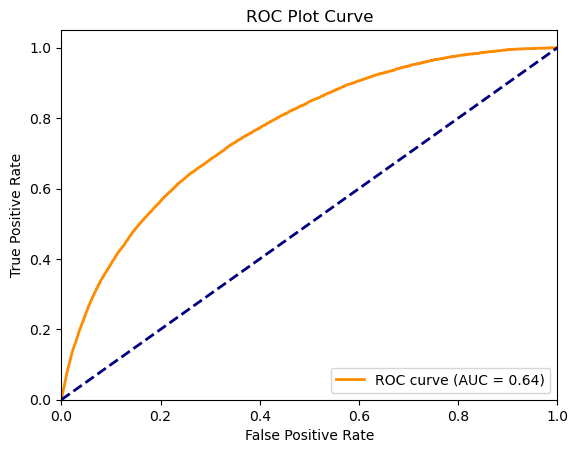

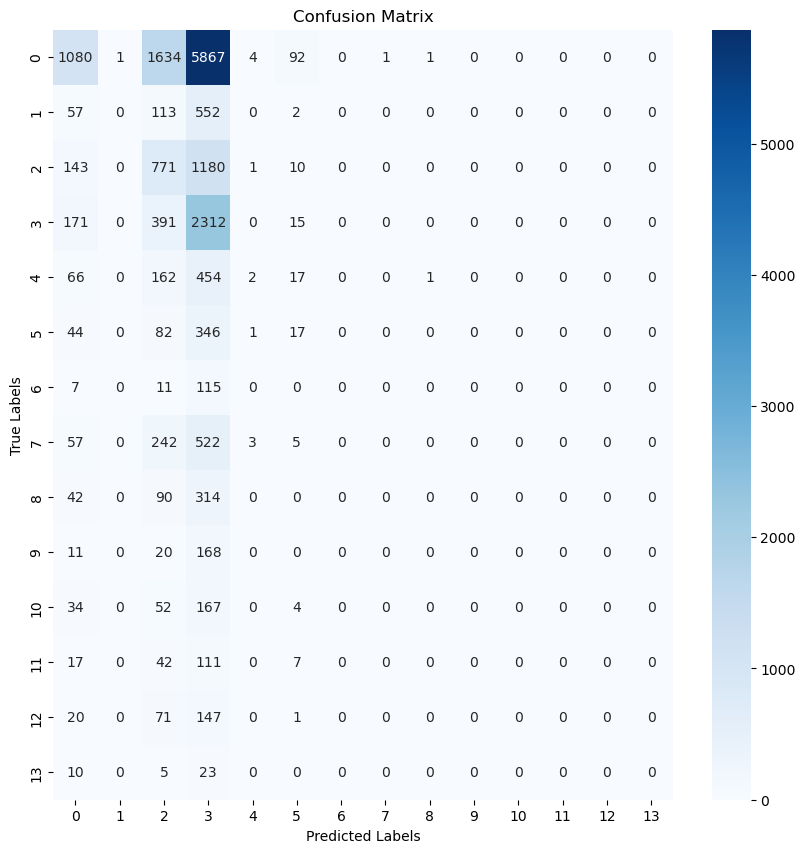

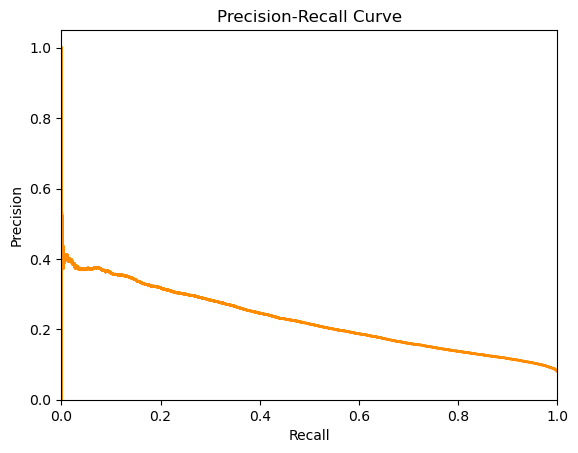

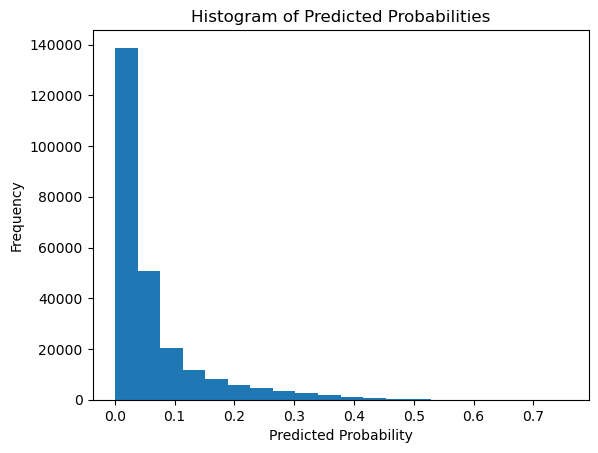

In [29]:
# plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Plot Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Histogram of predicted probabilities
plt.figure()
plt.hist(y_pred.ravel(), bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


# Model From Scratch

In [32]:

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import vision_transformer

# no weights
#pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with no weights
model = torchvision.models.vit_b_16()

# Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False
    
# Change the classifier head (the last layer of vision transformer) 
#every other layer is freezed

#set_seeds()
# change your out_features according to number of classes defined, we have 14 classes 
model.heads = nn.Linear(in_features=768, out_features=14)
# pretrained_vit # uncomment for model output 

model.to(device)  # to put the whole architecture to gpu memory
print(model)
criterion = nn.BCEWithLogitsLoss()
#criterion=nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)



VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [33]:
#train
model.train()
num_epochs = 2
for epoch in range(num_epochs):
    
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

100%|██████████| 1049/1049 [17:35<00:00,  1.01s/it]


Epoch [1/2], Loss: 0.1753


100%|██████████| 1049/1049 [17:08<00:00,  1.02it/s]

Epoch [2/2], Loss: 0.1603


In [34]:
#Evaluate
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

model.eval()
auc_scores = []    
running_loss = 0.0
running_corrects = torch.zeros(14).to(device)
total_samples = 0
num_labels = 14

with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        predicted_labels = torch.sigmoid(outputs) > 0.5
        predicted_probs = torch.sigmoid(outputs)
                
        running_corrects += (predicted_labels == labels).sum(dim=0).float()
        total_samples += inputs.size(0)
        y_pred.append(predicted_probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

epoch_loss = running_loss / total_samples
epoch_acc = running_corrects / total_samples
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
auc_score = roc_auc_score(y_true, y_pred, average='macro')

#auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr') 
print(f'Validation Loss: {epoch_loss:.4f} | Validation Acc: {epoch_acc.tolist()} | AUC score: {auc_score:.4f}')


100%|██████████| 280/280 [04:47<00:00,  1.03s/it]

Validation Loss: 0.2611 | Validation Acc: [0.8639714121818542, 0.9518651366233826, 0.8197453618049622, 0.7451977133750916, 0.9238329529762268, 0.93650883436203, 0.9757091999053955, 0.9026134014129639, 0.9191423058509827, 0.9594036340713501, 0.9563882350921631, 0.9787804484367371, 0.9539870619773865, 0.995923638343811] | AUC score: 0.5867


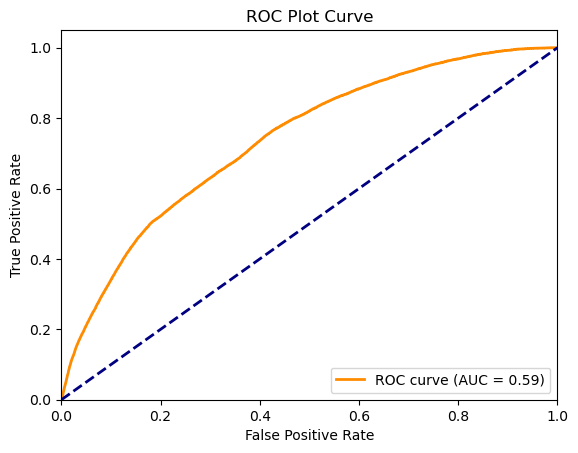

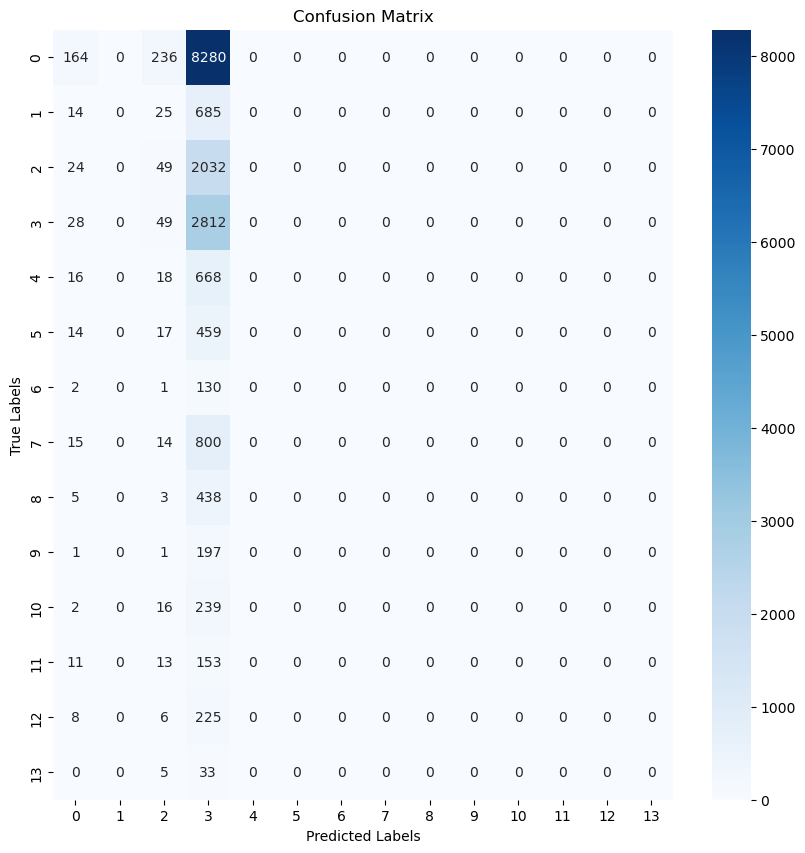

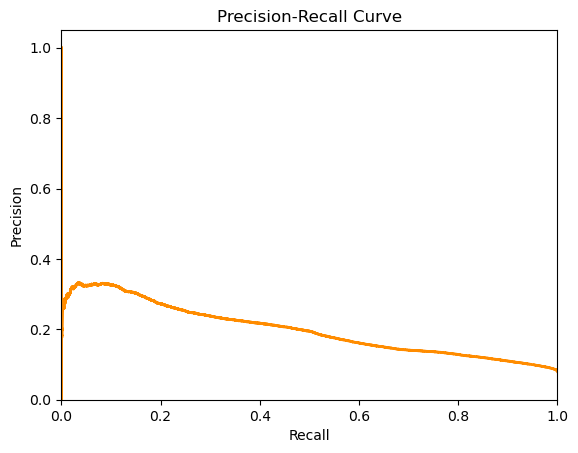

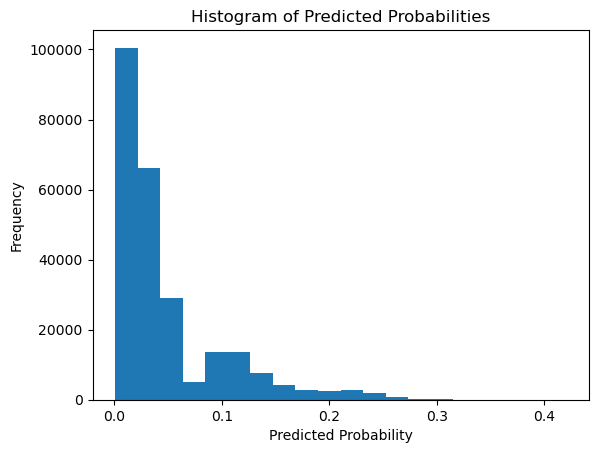

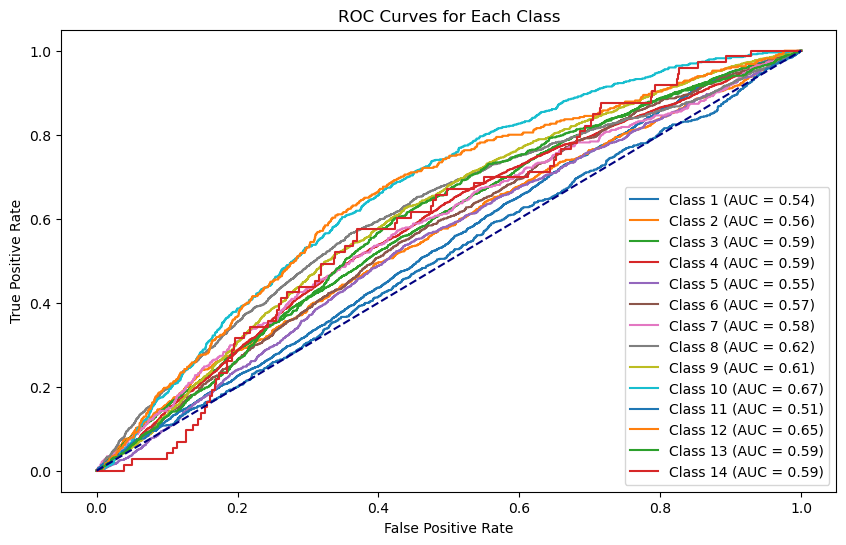

In [43]:
# plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Plot Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Histogram of predicted probabilities
plt.figure()
plt.hist(y_pred.ravel(), bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_labels):
    fpr_i, tpr_i, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'Class {i + 1} (AUC = {roc_auc_i:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()
